In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
import sklearn
import shap

shap.initjs()

import warnings
warnings.filterwarnings('ignore')

# Explaining AutoGluon-Tabular Predictions with Kernel SHAP

We recommend first starting with this tutorial before the other SHAP tutorials. This example uses the original version of <a href="https://archive.ics.uci.edu/ml/datasets/Adult">adult census income dataset</a>, which is a binary classification task with categorical & numerical features. The code shown here should also work if you have text columns in your dataset and for regression or multiclass classification problems. We train an AutoGluon classifier and then explain each of its predictions via [Shapely values](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) that quantify how much each feature contributed to a particular AutoGluon-prediction deviating from some "baseline" value. We use the [Kernel SHAP variant](https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html) which is appropriate for explaining arbitrary black-box models like the potentially heterogeneous ensemble of many models that AutoGluon-Tabular uses to make its predictions.

You must first install the [SHAP package](https://github.com/slundberg/shap/) (`pip install shap`).

**Note:**  Unlike the [similar notebooks](https://shap.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Census%20income%20classification%20with%20scikit-learn.html) from the SHAP package, this example shows you how to apply Kernel SHAP to data with categorical features. In the second half of this notebook, we also demonstrate Shapely values for interpreting predictions in multiclass classification tasks with more than 2 classes.

## Load the raw census data

Note these data contain categorical as well as numerical features. We first consider predicting the `class` column, a binary classification task. 

In [2]:
N_SUBSAMPLE = 500  # subsample datasets for faster demo
N_TEST = 50

train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')  # can be local CSV file as well, returns Pandas DataFrame
train_data = train_data.sample(N_SUBSAMPLE, random_state=0)
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv') # another Pandas DataFrame
test_data = test_data.sample(N_TEST, random_state=0)

label = 'class'

y_train = train_data[label]
y_test = test_data[label]
X_train = pd.DataFrame(train_data.drop(columns=[label]))
X_test = pd.DataFrame(test_data.drop(columns=[label]))

display(train_data.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
6118,51,Private,39264,Some-college,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,>50K
23204,58,Private,51662,10th,6,Married-civ-spouse,Other-service,Wife,White,Female,0,0,8,United-States,<=50K
29590,40,Private,326310,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States,<=50K
18116,37,Private,222450,HS-grad,9,Never-married,Sales,Not-in-family,White,Male,0,2339,40,El-Salvador,<=50K
33964,62,Private,109190,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,40,United-States,>50K


## Train binary classifier using AutoGluon

In [3]:
predictor = TabularPredictor(label=label, problem_type='binary').fit(train_data, time_limit=120)

No path specified. Models will be saved in: "AutogluonModels/ag-20250625_073525"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
CPU Count:          64
Memory Avail:       83.14 GB / 93.79 GB (88.6%)
Disk Space Avail:   678.22 GB / 915.32 GB (74.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use

### Explain predictions

SHAP is intended to explain how much each feature contributes to a particular prediction. For  classification, "how much" is quantified in terms of the deviation between predicted probability of a particular class from a baseline reference value. In this example, we will  explain predictions of the " >50K" class.

In [4]:
target_class = " >50K"  # can be any possible value of the label column

Next we create a wrapper class around AutoGluon to allow it to be called for prediction inside of the `shap` package:

In [5]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names, target_class=None):
        self.ag_model = predictor
        self.feature_names = feature_names
        self.target_class = target_class
        if target_class is None and predictor.problem_type != 'regression':
            print("Since target_class not specified, SHAP will explain predictions for each class")
    
    def predict_proba(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        preds = self.ag_model.predict_proba(X)
        if predictor.problem_type == "regression" or self.target_class is None:
            return preds
        else:
            return preds[self.target_class]    

Next, we must define the baseline reference value for SHAP. In this example, we aggregate all of the training examples with label " <50K" (the negative class in our binary classification task) as our baseline (and take a random subsample of these for efficiency).

In [6]:
negative_class = " <=50K"
baseline = X_train[y_train==negative_class].sample(50, random_state=0)
display(baseline.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
26097,23,?,146399,Bachelors,13,Never-married,?,Not-in-family,White,Male,0,0,55,United-States
32812,44,?,256211,Assoc-voc,11,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,2129,40,Poland
9888,27,Private,169557,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,White,Male,6849,0,40,United-States
9538,45,Private,204057,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,Germany
21531,28,Private,257283,HS-grad,9,Never-married,Transport-moving,Own-child,White,Male,0,0,40,United-States


AutoGluon predictions will be interpreted in terms of their difference from the average prediction across the baseline feature-values (i.e. the prediction for a new datapoint will explained by quantifying how much each feature contributes to this prediction differing from the average prediction over the rows in our baseline DataFrame). With the target class and baseline we chose in this example, SHAP will indicate **why** a particular predicted probability of the " >50K" class deviated from the average predicted probability of the " <=50K" class across the training data. The **why** is reported in terms of how each individual feature contributed to the overall deviation of this prediction from the baseline value (ie. the Shapely values).

We can now create a `KernelExplainer` which will return Kernel SHAP values to explain particular AutoGluon predictions.

In [7]:
ag_wrapper = AutogluonWrapper(predictor, X_train.columns, target_class)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)
print("Baseline prediction: ", np.mean(ag_wrapper.predict_proba(baseline)))  # this is the same as explainer.expected_value

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower

Baseline prediction:  0.11633540893904865


Let's first explain a prediction for a single datapoint from the training data.

In [14]:
shap.initjs()

In [15]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_proba(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)


shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

**Note:** If you ever see message "Visualization omitted, Javascript library not loaded", simply re-running the corresponding cells should show the plots. If you don't have Javascript, you may stil produce plots by adding argument: `force_plot(..., matplotlib=True)`.

We can also plot Kernel SHAP explanations aggregated across many predictions, say over all the datapoints in the test data.

In [16]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values, X_test)  # if you do not have add argument 

  0%|          | 0/50 [00:00<?, ?it/s]

A summary plot is an even better way to see the relative impact of all features over many datapoints. Features are sorted by the sum of their SHAP value magnitudes across all samples.

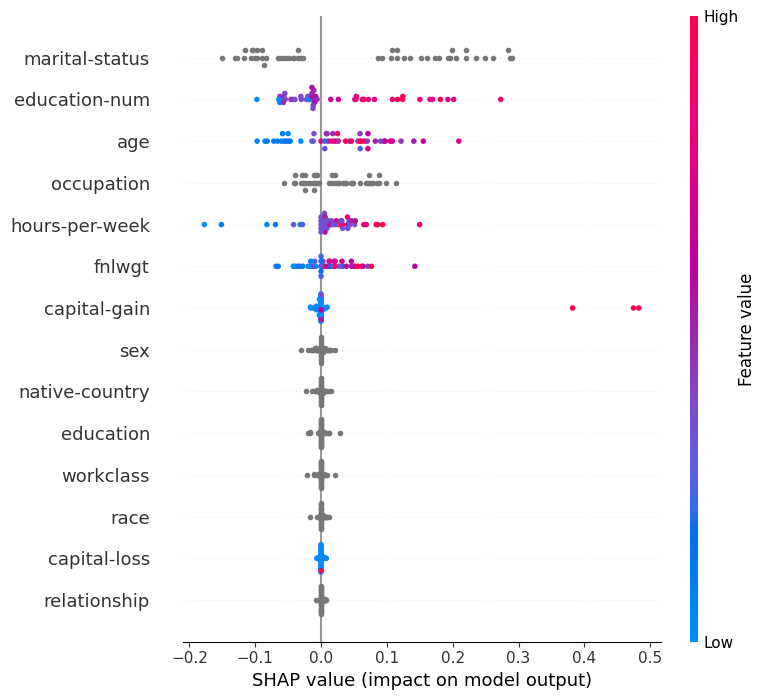

In [17]:
shap.summary_plot(shap_values, X_test)

A dependence plot can be used to visualize how the number of years of education increases the chance of making over 50K annually.

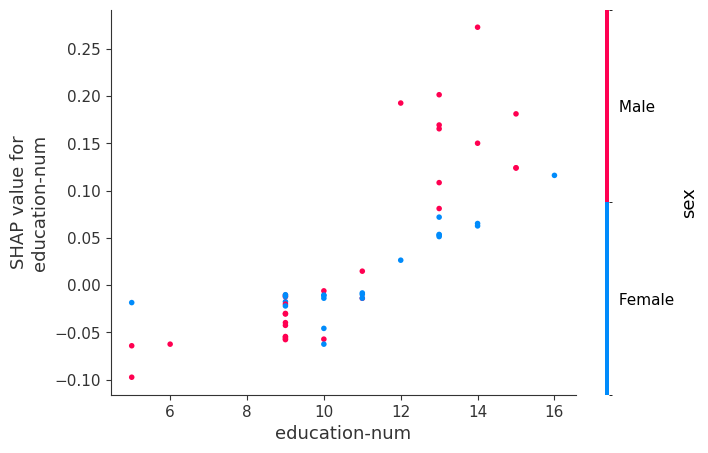

In [18]:
shap.dependence_plot("education-num", shap_values, X_test)

## Scoring Overall Feature Importance via Permutation Shuffling

Note that if you'd like to understand how much each feature contributes to AutoGluon's general predictive accuracy (rather than explaining individual predictions), AutoGluon offers a built-in method for this based on [permutation-shuffling](https://explained.ai/rf-importance/):

In [19]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 14 features using 50 rows with 5 shuffle sets...
	1.18s	= Expected runtime (0.24s per shuffle set)
	0.08s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
marital-status,0.104,0.029665,0.000715,5,0.165080,0.042920
education-num,0.084,0.021909,0.000508,5,0.129111,0.038889
age,0.064,0.035777,0.008065,5,0.137666,-0.009666
capital-gain,0.064,0.029665,0.004249,5,0.125080,0.002920
hours-per-week,0.008,0.017889,0.186950,5,0.044833,-0.028833
workclass,0.000,0.000000,0.500000,5,0.000000,0.000000
capital-loss,0.000,0.000000,0.500000,5,0.000000,0.000000
education,0.000,0.000000,0.500000,5,0.000000,0.000000
relationship,0.000,0.000000,0.500000,5,0.000000,0.000000
race,0.000,0.000000,0.500000,5,0.000000,0.000000


Features with near zero or negative importance score above hardly contribute at all to AutoGluon's overall accuracy on the test data, whereas features near the top of this list contain the most predictive signal.

# Explaining predictions for multiple classes

Let's now repeat this same analysis for a multiclass classification problem with more than 2 classes. We'll use the same dataset and predict the `relationship` variable based on the other columns' values. For interpreting predictions in multiclass classification, SHAP will quantify how much each feature contributes to the predicted probability for each class separately.

In [20]:
label = 'relationship'

y_train = train_data[label]
y_test = test_data[label]
X_train = pd.DataFrame(train_data.drop(columns=[label]))
X_test = pd.DataFrame(test_data.drop(columns=[label]))

display(train_data.head())
print("Possible classes: \n", train_data[label].value_counts())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
6118,51,Private,39264,Some-college,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,>50K
23204,58,Private,51662,10th,6,Married-civ-spouse,Other-service,Wife,White,Female,0,0,8,United-States,<=50K
29590,40,Private,326310,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,44,United-States,<=50K
18116,37,Private,222450,HS-grad,9,Never-married,Sales,Not-in-family,White,Male,0,2339,40,El-Salvador,<=50K
33964,62,Private,109190,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,40,United-States,>50K


Possible classes: 
 relationship
Husband           219
Not-in-family     134
Own-child          66
Unmarried          43
Wife               25
Other-relative     13
Name: count, dtype: int64


Fit an AutoGluon classifier:

In [21]:
predictor_multi = TabularPredictor(label=label, problem_type='multiclass').fit(train_data, time_limit=20)

No path specified. Models will be saved in: "AutogluonModels/ag-20250625_073748"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
CPU Count:          64
Memory Avail:       82.14 GB / 93.79 GB (87.6%)
Disk Space Avail:   678.20 GB / 915.32 GB (74.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use

Now we will use a baseline value that is a vector of predicted probabilities (for each class), here simply taken over a random subsample of the training data. For a particular prediction, we will produce a separate set of Shapely values for each class, which quantify how much each feature contributes the particular prediction deviating from the baseline probability value for that class.

In [22]:
baseline = X_train.sample(100, random_state=0)

ag_wrapper = AutogluonWrapper(predictor_multi, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)
print("Baseline prediction: \n", ag_wrapper.predict_proba(baseline).mean())  # this is the same as explainer.expected_value

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower
shap.initjs()

Since target_class not specified, SHAP will explain predictions for each class
Baseline prediction: 
 Husband           0.427679
Not-in-family     0.274159
Other-relative    0.021522
Own-child         0.136484
Unmarried         0.081629
Wife              0.058526
dtype: float32


Again we can compute the Shapely values for an individual prediction. Note that some SHAP functions like `force_plot`, `dependence_plot` will not work in this multiclass setting, as they can only operate with a single set of Shapely values. For these plots, we will thus only focus on the Shapely values corresponding to one target class of interest. 

In [29]:
shap.initjs()

In [31]:

ROW_INDEX = 0  # index of an example datapoint
class_of_interest = ' Not-in-family'  # can be any value in set(y_train)
class_index = predictor_multi.class_labels.index(class_of_interest)

single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_proba(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
print(f"Force_plot for class: {class_of_interest}")

shap.force_plot(
    explainer.expected_value[class_index],                  # The base value for the selected class
    shap_values_single[ROW_INDEX, :, class_index],                 # SHAP values for the selected sample and class
    X_test.iloc[ROW_INDEX, :]                               # Original feature values of the selected sample
)


  0%|          | 0/1 [00:00<?, ?it/s]

Force_plot for class:  Not-in-family


Next we again plot aggregated Shapely values for predictions for every datapoint in the test data (for the class of interest), as well as a summary_plot, and dependence_plot (for the class of interest, as well as a particular feature of interest).

In [32]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES)

shap.force_plot(
    explainer.expected_value[class_index],                  # The base value for the selected class
    shap_values[:, :, class_index],                         # SHAP values for all samples with respect to the selected class
    X_test                                                  # Original test data (feature values)
)


  0%|          | 0/50 [00:00<?, ?it/s]

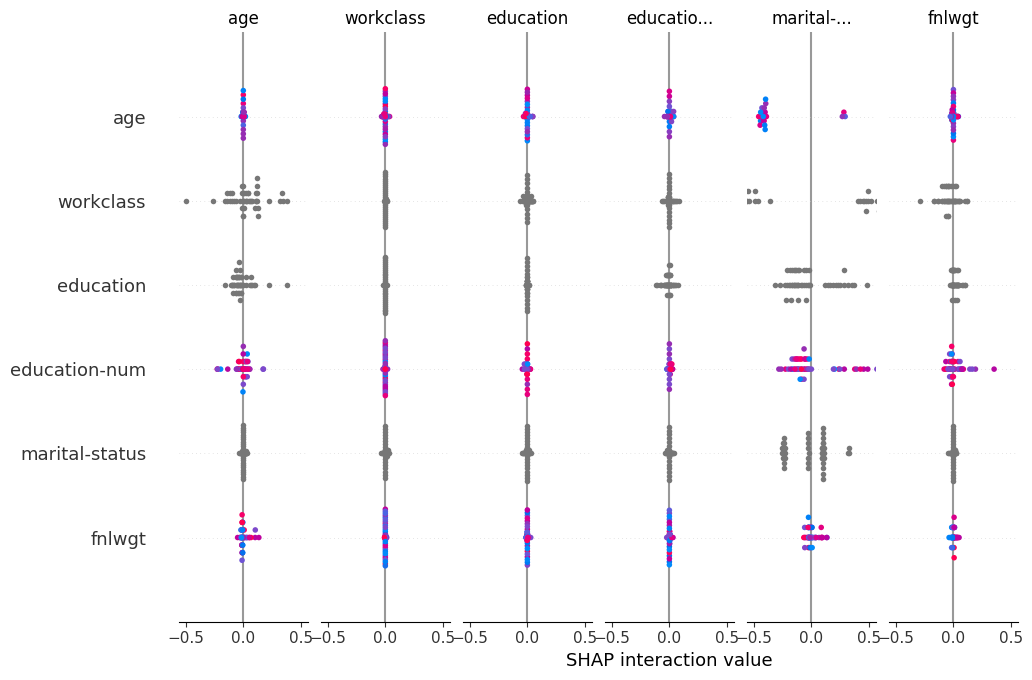

{'Class 0': ' Husband', 'Class 1': ' Not-in-family', 'Class 2': ' Other-relative', 'Class 3': ' Own-child', 'Class 4': ' Unmarried', 'Class 5': ' Wife'}


In [33]:
shap.summary_plot(shap_values, X_test)
print({"Class "+str(i) : predictor_multi.class_labels[i] for i in range(len(predictor_multi.class_labels))})

Dependence_plot for class:  Not-in-family  and for feature: marital-status 



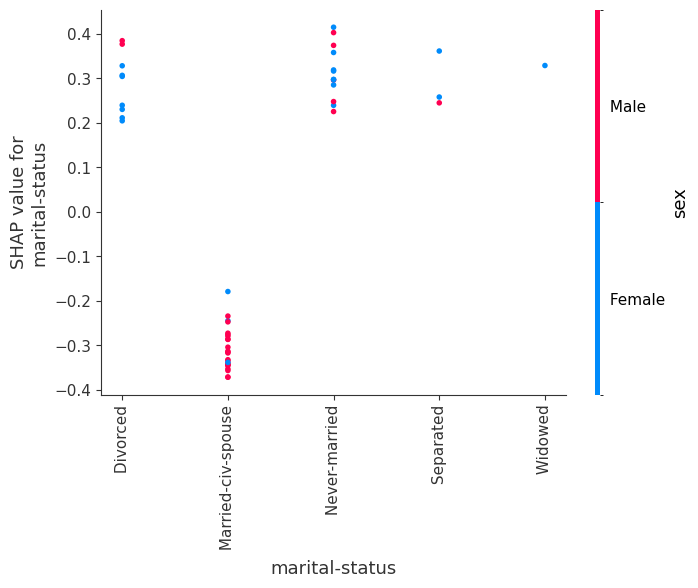

In [34]:
dependence_feature = "marital-status"
print(f"Dependence_plot for class: {class_of_interest}  and for feature: {dependence_feature} \n")
shap.dependence_plot(
    dependence_feature,                   
    shap_values[:, :, class_index],  
    X_test
)

For multiclass problems, we can still score overall feature importance (how much each feature contributes to predictive accuracy) using AutoGluon's built-in permutation procedure:

In [35]:
predictor_multi.feature_importance(test_data)

Computing feature importance via permutation shuffling for 14 features using 50 rows with 5 shuffle sets...
	1.23s	= Expected runtime (0.25s per shuffle set)
	0.09s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
marital-status,0.368,0.030332,0.000005,5,0.430453,0.305547
sex,0.208,0.057619,0.000640,5,0.326639,0.089361
occupation,0.032,0.022804,0.017460,5,0.078953,-0.014953
class,0.028,0.010954,0.002318,5,0.050555,0.005445
age,0.020,0.024495,0.070964,5,0.070435,-0.030435
education-num,0.016,0.016733,0.049650,5,0.050454,-0.018454
education,0.004,0.008944,0.186950,5,0.022416,-0.014416
hours-per-week,0.004,0.016733,0.310654,5,0.038454,-0.030454
capital-gain,0.000,0.000000,0.500000,5,0.000000,0.000000
workclass,0.000,0.000000,0.500000,5,0.000000,0.000000
